<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S5/BASE-SST_Sentiment_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - using LSTM
Dataset : **Stanford Sentiment Treebank**

Steps covered in this notebook:
1. Knowing the data



# Setting Up

In [9]:
! pip install pytreebank

In [4]:
! git clone https://github.com/namanphy/END2.git

Cloning into 'END2'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 125 (delta 44), reused 88 (delta 23), pack-reused 0
Receiving objects: 100% (125/125), 6.75 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [5]:
cd /content/END2/S5

/content/END2/S5


In [6]:
! unzip /content/END2/S5/stanfordSentimentTreebank.zip 

Archive:  /content/END2/S5/stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  

In [7]:
ls

__MACOSX/  stanfordSentimentTreebank/  stanfordSentimentTreebank.zip


In [8]:
import pytreebank
import sys
import os
import pandas as pd

import torch, torchtext
from torchtext.legacy import data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Manual Seed
SEED = 45
torch.manual_seed(SEED)



---



# Preparing the data

SST consists of 11,855 sentences extracted from movie reviews with fine-grained sentiment labels [1–5], as well as 215,154 phrases that compose each sentence in the dataset.


## Generating train and test sentence-label dataframes
From raw txt files..

In [71]:
dataset = pytreebank.load_sst('./stanfordSentimentTreebank')
out_path = os.path.join('./stanfordSentimentTreebank', 'sst_{}.txt')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("{}\t\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

In [72]:
df_train = pd.read_csv(out_path.format('train'), sep='\t\t', header=None, names=['label', 'text'])
df_test = pd.concat((pd.read_csv(out_path.format(f), sep='\t\t', header=None, names=['label', 'text']) for f in ['test', 'dev']), 
                    ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [73]:
df_train.head(2)

,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...


In [74]:
print(df_train.shape)
print(df_test.shape)

(8544, 2)
(3311, 2)


Increasing the train dataset from 72% to 80%. Selecting randomly **940 samples** from the tes set.

In [75]:
df_train = pd.concat((df_train, df_test.sample(n=940, random_state=SEED)), ignore_index=True)
df_test = df_test.drop(df_test.sample(n=940, random_state=SEED).index)
df_test.reset_index(inplace=True)

In [76]:
# Final shapes of the datasets


print(df_train.shape)
print(df_test.shape)

(9484, 2)
(2371, 3)


## Knowing our Data

Our dataset is ofcourse not balanced. It is clear that most of the training samples belong to classes 2 and 4. Also a good number of samples belong to `neutral` class i.e. label 3.


Text(0, 0.5, 'Number of Samples in training Set')

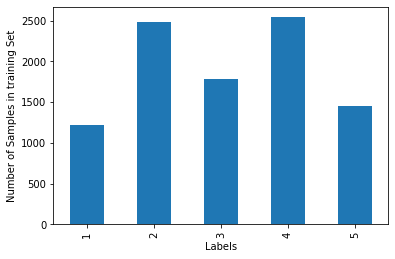

In [77]:
import matplotlib.pyplot as plt

ax = df_train['label'].value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Labels")
ax.set_ylabel("Number of Samples in training Set")

What's the distribution of the lengths of the data ?

**It has a average of 102 in the training set.**

count    9484.000000
mean      102.403205
std        51.212116
min         4.000000
25%        62.000000
50%        98.000000
75%       137.000000
max       267.000000
dtype: float64

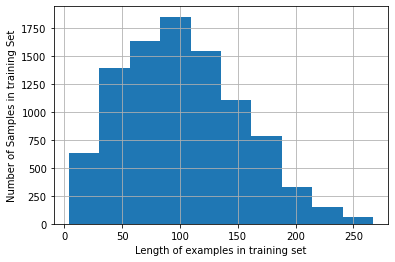

In [78]:
reviews_len = [len(x) for x in df_train['text']]
ax = pd.Series(reviews_len).hist()
ax.set_xlabel("Length of examples in training set")
ax.set_ylabel("Number of Samples in training Set")
pd.Series(reviews_len).describe()

## Making a torchtext dataset and dataloader

In [79]:
text = data.Field(sequential=True, tokenize='spacy', batch_first =True, include_lengths=True)
label = data.LabelField(sequential=False, tokenize ='spacy',  batch_first=True, is_target=True)

In [80]:
fields = [('texts', text), ('labels', label)]

In [81]:
# Generated Examples from the train and test data

train_example = [data.Example.fromlist([df_train.text[i], df_train.label[i]], fields) for i in range(df_train.shape[0])]
test_example = [data.Example.fromlist([df_test.text[i], df_test.label[i]], fields) for i in range(df_test.shape[0])]

#### Building Dataset

In [82]:
train_dataset = data.Dataset(train_example, fields)
test_dataset = data.Dataset(test_example, fields)

In [83]:
print('Length of training dataset: ', len(train_dataset))
print('Length of testing dataset: ', len(test_dataset))

Length of training dataset:  9484
Length of testing dataset:  2371


#### Building Vocab

In [84]:
text.build_vocab(train_dataset)
label.build_vocab(train_dataset)

In [85]:
print('Size of input vocab : ', len(text.vocab))
print('Size of label vocab : ', len(label.vocab))
print('Top 10 words appreared repeatedly :', list(text.vocab.freqs.most_common(10)))
print('Labels : ', label.vocab.stoi)

Size of input vocab :  18089
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 8933), (',', 7940), ('the', 6736), ('and', 4985), ('a', 4902), ('of', 4895), ('to', 3388), ('-', 3018), ("'s", 2844), ('is', 2807)]
Labels :  defaultdict(None, {4: 0, 2: 1, 3: 2, 5: 3, 1: 4})


**Lots of stopwords!! YES INDEED!!**

#### Making a data iterator

In [169]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [170]:
train_iterator, test_iterator = data.BucketIterator.splits((train_dataset, test_dataset), 
                                                           batch_size=16, 
                                                           sort_key=lambda x: len(x.texts),
                                                           sort_within_batch=True,
                                                           device=device)

**Notice that i haven't used padding for my sentences(data) here.**

In [171]:
print('Train')
for batch in train_iterator:
    print(f'Text size: {batch.texts[0].size()}')
    print(f'Label size: {batch.labels.size()}')
    break

print('\nTest:')
for batch in test_iterator:
    print(f'Text size: {batch.texts[0].size()}')
    print(f'Label size: {batch.labels.size()}')
    break

Train
Text size: torch.Size([16, 34])
Label size: torch.Size([16])

Test:
Text size: torch.Size([16, 3])
Label size: torch.Size([16])


In [172]:
import pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(text.vocab.stoi, tokens)

# Model Preparation

In [181]:
class classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 
                            num_layers=n_layers, 
                            # dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text, text_length):
        embedded = self.embedding(text)  # [batch size, sent_length] -> [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'), batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions, hid dim]
        #cell = [batch size, num layers * num directions, hid dim]

        # print('Hidden shape ; ', hidden.shape)

        dense_outputs = self.fc(hidden)  # [batch size, hid dim * num directions] -> [batch size, output dim]
        
        # print('Output shape ; ', dense_outputs.shape)
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
        return output

In [182]:
# Hyperparams
size_of_vocab = len(text.vocab)
embedding_dim = 300
num_hidden_nodes = 150
num_output_nodes = 5
num_layers = 2
# dropout = 0.2

model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers)

In [183]:
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(18089, 300)
  (lstm): LSTM(300, 150, num_layers=2, batch_first=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
)
The model has 5,879,855 trainable parameters


# Training

In [184]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

model = model.to(device)
criterion = criterion.to(device)

### **Training Loop**

In [185]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:

        texts, texts_lengths = batch.texts   
        
        predictions = model(texts, texts_lengths).squeeze()
        
        # print(predictions.shape, batch.labels.shape)
        loss = criterion(predictions, batch.labels)    
        optimizer.zero_grad()    
        acc = binary_accuracy(predictions, batch.labels)   
        
        loss.backward()       
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### **Evaluation Loop**

In [186]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            texts, texts_lengths = batch.texts

            predictions = model(texts, texts_lengths).squeeze()
            
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### **Let's Train and Evaluate**

In [187]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [180]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(valid_loss)
    test_accuracies.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Streaming output truncated to the last 5000 lines.
Output shape ;  torch.Size([16, 5]) torch.Size([2, 16, 5])
torch.Size([16, 5]) torch.Size([16])
Hidden shape ;  torch.Size([2, 16, 150])
Output shape ;  torch.Size([2, 16, 5])
Output shape ;  torch.Size([16, 5]) torch.Size([2, 16, 5])
torch.Size([16, 5]) torch.Size([16])
Hidden shape ;  torch.Size([2, 16, 150])
Output shape ;  torch.Size([2, 16, 5])
Output shape ;  torch.Size([16, 5]) torch.Size([2, 16, 5])
torch.Size([16, 5]) torch.Size([16])
Hidden shape ;  torch.Size([2, 16, 150])
Output shape ;  torch.Size([2, 16, 5])
Output shape ;  torch.Size([16, 5]) torch.Size([2, 16, 5])
torch.Size([16, 5]) torch.Size([16])
Hidden shape ;  torch.Size([2, 16, 150])
Output shape ;  torch.Size([2, 16, 5])
Output shape ;  torch.Size([16, 5]) torch.Size([2, 16, 5])
torch.Size([16, 5]) torch.Size([16])
Hidden shape ;  torch.Size([2, 16, 150])
Output shape ;  torch.Size([2, 16, 5])
Output shape ;  torch.Size([16, 5]) torch.Size([2, 16, 5])
torch.Size

# Evaluation

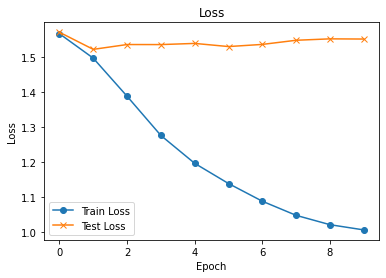

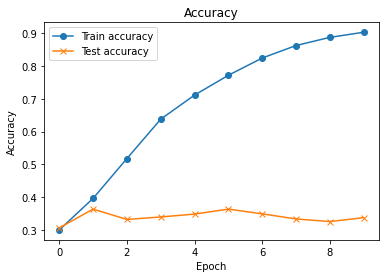

In [192]:
# Plotting metrics to see how model as learned and loss decreased
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCHS), train_losses, marker='o')
plt.plot(range(N_EPOCHS), test_losses, marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.title("Loss")
#plt.ylim([0,100])
plt.show()

print("\n")

plt.plot(range(N_EPOCHS), train_accuracies, marker='o')
plt.plot(range(N_EPOCHS), test_accuracies, marker = 'x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy", "Test accuracy"])
plt.title("Accuracy")
# plt.ylim([50,100])
plt.show()

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
